In [25]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder , FunctionTransformer
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix, recall_score, accuracy_score, precision_score, f1_score, roc_auc_score

In [2]:
df = pd.read_csv("data/data_clean.csv")
df = df.drop("Unnamed: 0",axis=1)
df.head()

,funder,gps_height,installer,wpt_name,basin,region_code,district_code,population,public_meeting,permit,extraction_type_class,management,payment_type,quality_group,quantity,source,source_class,waterpoint_type,status_group,construction_year_bins
0,other,1390,other,none,Lake Nyasa,11,5,109,1.0,0.0,gravity,vwc,annually,good,enough,spring,groundwater,communal standpipe,functional,"(1990.0, 2000.0]"
1,other,1399,other,Zahanati,Lake Victoria,20,2,280,NaN,1.0,gravity,wug,never pay,good,insufficient,rainwater harvesting,surface,communal standpipe,functional,"(2000.0, 2010.0]"
2,other,686,other,other,Pangani,21,4,250,1.0,1.0,gravity,vwc,per bucket,good,enough,dam,surface,communal standpipe multiple,functional,"(2000.0, 2010.0]"
3,other,263,other,other,Ruvuma / Southern Coast,90,63,58,1.0,1.0,submersible,vwc,never pay,good,dry,machine dbh,groundwater,communal standpipe multiple,non functional,"(1980.0, 1990.0]"
4,other,0,other,Shuleni,Lake Victoria,18,1,0,1.0,1.0,gravity,other,never pay,good,seasonal,rainwater harvesting,surface,communal standpipe,functional,"(1980.0, 1990.0]"


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   funder                  59400 non-null  object 
 1   gps_height              59400 non-null  int64  
 2   installer               59400 non-null  object 
 3   wpt_name                59400 non-null  object 
 4   basin                   59400 non-null  object 
 5   region_code             59400 non-null  int64  
 6   district_code           59400 non-null  int64  
 7   population              59400 non-null  int64  
 8   public_meeting          56066 non-null  float64
 9   permit                  56344 non-null  float64
 10  extraction_type_class   59400 non-null  object 
 11  management              59400 non-null  object 
 12  payment_type            59400 non-null  object 
 13  quality_group           59400 non-null  object 
 14  quantity                59400 non-null

In [4]:
def int_to_object(df):
    df["region_code"] = df["region_code"].astype(object)
    df["district_code"] = df["district_code"].astype(object)
    df["public_meeting"] = df["public_meeting"].astype(str)
    df["permit"] = df["permit"].astype(str)
    df["construction_year_bins"] = df["construction_year_bins"].astype(str)
    return df.dtypes

In [5]:
int_to_object(df)

funder                    object
gps_height                 int64
installer                 object
wpt_name                  object
basin                     object
region_code               object
district_code             object
population                 int64
public_meeting            object
permit                    object
extraction_type_class     object
management                object
payment_type              object
quality_group             object
quantity                  object
source                    object
source_class              object
waterpoint_type           object
status_group              object
construction_year_bins    object
dtype: object

In [6]:
X = df.drop('status_group', axis=1)
y = df['status_group']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [8]:
map_dict = {"functional": 1, "non functional": 2, "functional needs repair": 3}
y_train = y_train.map(map_dict)
y_test = y_test.map(map_dict)

In [9]:
y_train.value_counts()

1    24161
2    17146
3     3243
Name: status_group, dtype: int64

In [10]:
def grab_numeric(df):
    return df.select_dtypes(include=['int64'])

In [11]:
GrabNumeric = FunctionTransformer(grab_numeric)

In [12]:
pipe= Pipeline(steps=[("num", GrabNumeric),
                      ( "ss", StandardScaler())])

In [13]:
pipe.fit(X_train)

Pipeline(steps=[('num',
                 FunctionTransformer(func=<function grab_numeric at 0x1278b6ca0>)),
                ('ss', StandardScaler())])

In [14]:
pipe.transform(X_train)

array([[-0.48786917, -0.20973197],
       [-0.96404191, -0.37956688],
       [-0.96404191, -0.37956688],
       ...,
       [-0.98280023,  1.74336955],
       [-0.96404191, -0.37956688],
       [ 0.89736062, -0.37744395]])

In [15]:
j = -1
for i in X_train.columns:
    j+=1
    print("Index Number", j,i)

Index Number 0 funder
Index Number 1 gps_height
Index Number 2 installer
Index Number 3 wpt_name
Index Number 4 basin
Index Number 5 region_code
Index Number 6 district_code
Index Number 7 population
Index Number 8 public_meeting
Index Number 9 permit
Index Number 10 extraction_type_class
Index Number 11 management
Index Number 12 payment_type
Index Number 13 quality_group
Index Number 14 quantity
Index Number 15 source
Index Number 16 source_class
Index Number 17 waterpoint_type
Index Number 18 construction_year_bins


In [16]:
#Mini-Pipelines for our ColumnTransformer.

subpipe_num = Pipeline(steps=[('num_impute', SimpleImputer(strategy="median")),
                           ('ss', StandardScaler())])
subpipe_cat = Pipeline(steps=[('cat_impute', SimpleImputer(strategy='constant')),
                             ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))])


In [17]:
CT = ColumnTransformer(transformers=[('subpipe_num', subpipe_num, [1,7]),
                                         ('subpipe_cat', subpipe_cat, [0,2,3,4,5,6,8,9,10,11,12,13,14,15,16,17,18])])

In [20]:
!pip install catboost 

  Using cached catboost-1.0.4-cp38-none-macosx_10_6_intel.macosx_10_9_intel.macosx_10_9_x86_64.macosx_10_10_intel.macosx_10_10_x86_64.whl (12.7 MB)
  Using cached graphviz-0.19.1-py3-none-any.whl (46 kB)


In [22]:
from catboost import CatBoostClassifier, Pool

In [23]:
cat_boost_pipe2 = Pipeline([('ct', CT), ('cat', CatBoostClassifier(max_ctr_complexity=5, iterations=10000,eval_metric="AUC", od_type="Iter", od_wait=500))])
cat_boost_pipe2.fit(X_train, y_train)

Learning rate set to 0.013722
0:	total: 269ms	remaining: 44m 49s
1:	total: 335ms	remaining: 27m 54s
2:	total: 377ms	remaining: 20m 55s
3:	total: 402ms	remaining: 16m 43s
4:	total: 828ms	remaining: 27m 35s
5:	total: 1.28s	remaining: 35m 40s
6:	total: 1.35s	remaining: 32m 14s
7:	total: 1.49s	remaining: 30m 56s
8:	total: 1.71s	remaining: 31m 37s
9:	total: 1.87s	remaining: 31m 11s
10:	total: 2.03s	remaining: 30m 43s
11:	total: 2.19s	remaining: 30m 20s
12:	total: 2.38s	remaining: 30m 25s
13:	total: 2.55s	remaining: 30m 17s
14:	total: 2.72s	remaining: 30m 10s
15:	total: 2.83s	remaining: 29m 26s
16:	total: 3.1s	remaining: 30m 17s
17:	total: 3.2s	remaining: 29m 36s
18:	total: 3.25s	remaining: 28m 28s
19:	total: 3.29s	remaining: 27m 23s
20:	total: 3.45s	remaining: 27m 20s
21:	total: 3.55s	remaining: 26m 49s
22:	total: 3.7s	remaining: 26m 45s
23:	total: 3.79s	remaining: 26m 14s
24:	total: 3.9s	remaining: 25m 54s
25:	total: 3.97s	remaining: 25m 21s
26:	total: 4.09s	remaining: 25m 11s
27:	total: 4

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  [1, 7]),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='constant')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                               

In [24]:
cat_boost_pipe2.score(X_train, y_train)

0.8299887766554433

In [26]:
cross_validate(cat_boost_pipe2, X_train, y_train, return_train_score=True)

Learning rate set to 0.013567
0:	total: 53.4ms	remaining: 8m 54s
1:	total: 123ms	remaining: 10m 16s
2:	total: 184ms	remaining: 10m 13s
3:	total: 313ms	remaining: 13m 1s
4:	total: 379ms	remaining: 12m 36s
5:	total: 429ms	remaining: 11m 55s
6:	total: 504ms	remaining: 12m
7:	total: 597ms	remaining: 12m 25s
8:	total: 675ms	remaining: 12m 28s
9:	total: 781ms	remaining: 13m
10:	total: 843ms	remaining: 12m 45s
11:	total: 924ms	remaining: 12m 48s
12:	total: 1.01s	remaining: 12m 57s
13:	total: 1.1s	remaining: 13m 8s
14:	total: 1.22s	remaining: 13m 34s
15:	total: 1.31s	remaining: 13m 36s
16:	total: 1.38s	remaining: 13m 28s
17:	total: 1.44s	remaining: 13m 18s
18:	total: 1.47s	remaining: 12m 51s
19:	total: 1.54s	remaining: 12m 47s
20:	total: 1.56s	remaining: 12m 20s
21:	total: 1.6s	remaining: 12m 4s
22:	total: 1.61s	remaining: 11m 40s
23:	total: 1.64s	remaining: 11m 22s
24:	total: 1.68s	remaining: 11m 11s
25:	total: 1.73s	remaining: 11m 4s
26:	total: 1.77s	remaining: 10m 52s
27:	total: 1.79s	remai

{'fit_time': array([262.37729073, 324.34901404, 351.92559195, 624.42524624,
        842.22797632]),
 'score_time': array([1.13200212, 1.10327506, 0.99324083, 1.28413391, 1.24504495]),
 'test_score': array([0.79741863, 0.78967452, 0.78888889, 0.79450056, 0.78776655]),
 'train_score': array([0.83294052, 0.83392256, 0.8349046 , 0.83400673, 0.83285634])}

In [27]:
y_hat2 = cat_boost_pipe2.predict(X_test)

In [28]:
print(f"""
Our second model's accuracy on the test set is {accuracy_score(y_test, y_hat2)}. \n
Our second model's recall on the test set is {recall_score(y_test, y_hat2,average= 'weighted')} \n
Our second model's precision on the test set is {precision_score(y_test, y_hat2,average= 'weighted')} \n
Our second model's f1-score on the test is {f1_score(y_test, y_hat2,average= 'weighted')}.
""")


Our second model's accuracy on the test set is 0.7923232323232323. 

Our second model's recall on the test set is 0.7923232323232323 

Our second model's precision on the test set is 0.7874839213691799 

Our second model's f1-score on the test is 0.7813741983529287.



In [29]:
cat_boost_pipe3 = Pipeline([('ct', CT), ('cat', CatBoostClassifier(max_ctr_complexity=5, iterations=1000,eval_metric="AUC", od_type="Iter"))])
cat_boost_pipe3.fit(X_train, y_train)

Learning rate set to 0.096032
0:	total: 54.2ms	remaining: 54.1s
1:	total: 84.4ms	remaining: 42.1s
2:	total: 118ms	remaining: 39.2s
3:	total: 142ms	remaining: 35.3s
4:	total: 188ms	remaining: 37.5s
5:	total: 217ms	remaining: 35.9s
6:	total: 250ms	remaining: 35.5s
7:	total: 293ms	remaining: 36.3s
8:	total: 324ms	remaining: 35.6s
9:	total: 358ms	remaining: 35.5s
10:	total: 385ms	remaining: 34.6s
11:	total: 433ms	remaining: 35.6s
12:	total: 457ms	remaining: 34.7s
13:	total: 489ms	remaining: 34.4s
14:	total: 515ms	remaining: 33.8s
15:	total: 540ms	remaining: 33.2s
16:	total: 559ms	remaining: 32.3s
17:	total: 582ms	remaining: 31.8s
18:	total: 603ms	remaining: 31.1s
19:	total: 648ms	remaining: 31.8s
20:	total: 680ms	remaining: 31.7s
21:	total: 703ms	remaining: 31.2s
22:	total: 728ms	remaining: 30.9s
23:	total: 753ms	remaining: 30.6s
24:	total: 817ms	remaining: 31.9s
25:	total: 899ms	remaining: 33.7s
26:	total: 944ms	remaining: 34s
27:	total: 991ms	remaining: 34.4s
28:	total: 1.1s	remaining: 3

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  [1, 7]),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='constant')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                               

In [30]:
cat_boost_pipe3.score(X_train, y_train)

0.8182716049382716

In [18]:
dt_model_pipe = Pipeline(steps=([("ct", CT), 
                                    ("dt", DecisionTreeClassifier(random_state = 0))]))
dt_model_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  [1, 7]),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='constant')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                               

In [39]:
#Creating variable to use in GridSearch
from sklearn.metrics import make_scorer
scorer = make_scorer(recall_score, average = 'weighted')

In [40]:
dt_grid = [{'dt__max_depth': [2, 4, 6], 
         'dt__min_samples_leaf': [20, 25]}]


gridsearch = GridSearchCV(estimator=dt_model_pipe, 
                          param_grid=dt_grid, 
                          scoring=scorer, 
                          cv=5)

gridsearch.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(transformers=[('subpipe_num',
                                                                         Pipeline(steps=[('num_impute',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         [1,
                                                                          7]),
                                                                        ('subpipe_cat',
                                                                         Pipeline(steps=[('cat_impute',
                                                               

In [41]:
gridsearch.score(X_test, y_test)

0.7214141414141414

In [42]:
gridsearch.best_params_

{'dt__max_depth': 6, 'dt__min_samples_leaf': 20}

In [43]:
gridsearch.cv_results_['mean_test_score']

array([0.6935578 , 0.6935578 , 0.70190797, 0.70190797, 0.71946128,
       0.71928171])

In [44]:
t_predict= dt_model_pipe.predict(X_train)
t_test_predict = dt_model_pipe.predict(X_test)

print('Training Precision: ', precision_score(y_train, t_predict, average='weighted'))
print('Testing Precision: ', precision_score(y_test, t_test_predict, average='weighted'))
print('\n\n')

print('Training Recall: ', recall_score(y_train, t_predict, average='weighted'))
print('Testing Recall: ', recall_score(y_test, t_test_predict, average='weighted'))

Training Precision:  0.9467628668717257
Testing Precision:  0.74607781633105



Training Recall:  0.9462401795735129
Testing Recall:  0.7488888888888889


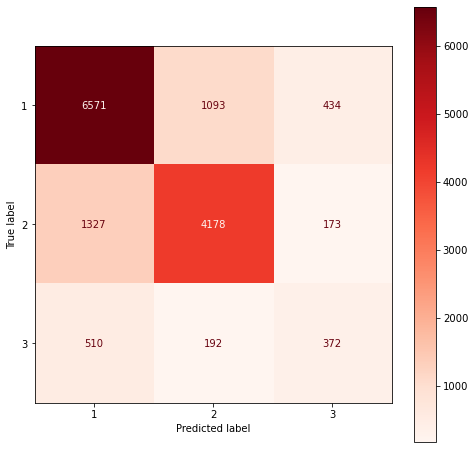

In [45]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_confusion_matrix(dt_model_pipe, X_test, y_test, cmap=plt.cm.Reds, ax=ax);

In [46]:
def model_evaluation(model, X_train, y_train, X_test, y_test):
    print(f"""
    Training Accuracy Score: {round(accuracy_score(y_train, model.predict(X_train)),2)} 
    Testing Accuracy Score: {round(accuracy_score(y_test, model.predict(X_test)),2)}
    
    Training Precision Score: {round(precision_score(y_train, model.predict(X_train), average= 'weighted'),2)}
    Testing Precision Score: {round(precision_score(y_test, model.predict(X_test), average= 'weighted'),2)} 
    
    Training Recall Score: {round(recall_score(y_train, model.predict(X_train), average= 'weighted'),2)}
    Testing Recall Score: {round(recall_score(y_test, model.predict(X_test), average= 'weighted'),2)} 
    
    Training F1 Score: {round(f1_score(y_train, model.predict(X_train), average= 'weighted'),2)}
    Testing F1 Score: {round(f1_score(y_test, model.predict(X_test), average= 'weighted'),2)} 
    
    Confusion Matrix:""")     
    fig, ax = plt.subplots(figsize=(8, 8))
    plot_confusion_matrix(model, X_test, y_test, normalize = 'true', display_labels = ['Functional', 'Functional Needs Repair', 'Nonfunctional'],ax=ax)                        
                                 
                                 


    Training Accuracy Score: 0.95 
    Testing Accuracy Score: 0.75
    
    Training Precision Score: 0.95
    Testing Precision Score: 0.75 
    
    Training Recall Score: 0.95
    Testing Recall Score: 0.75 
    
    Training F1 Score: 0.95
    Testing F1 Score: 0.75 
    
    Confusion Matrix:


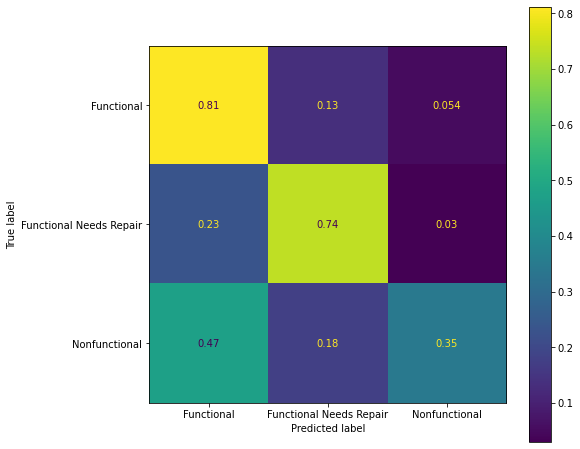

In [47]:
model_evaluation(dt_model_pipe, X_train, y_train, X_test, y_test)

In [ ]:
#Training ROC_AUC: {round(roc_auc_score(y_train, model.predict(X_train), average= 'macro'),2)}
#Testing ROC_AUC:  {round(roc_auc_score(y_test, model.predict(X_test), average= 'macro'),2)} 

In [48]:
dt1_model_pipe = Pipeline(steps=([("ct", CT), 
                                    ("dt", DecisionTreeClassifier(random_state = 0))]))
dt1_model_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  [1, 7]),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='constant')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                               

In [49]:
dt1_grid = [{'dt__max_depth': [6, 8, 10], 
         'dt__min_samples_leaf': [20, 22, 24]}]


gridsearch1 = GridSearchCV(estimator=dt1_model_pipe, 
                          param_grid=dt1_grid, 
                          scoring=scorer, 
                          cv=5)

gridsearch1.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(transformers=[('subpipe_num',
                                                                         Pipeline(steps=[('num_impute',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         [1,
                                                                          7]),
                                                                        ('subpipe_cat',
                                                                         Pipeline(steps=[('cat_impute',
                                                               

In [50]:
gridsearch1.score(X_test, y_test)

0.7349494949494949

In [51]:
gridsearch1.best_params_

{'dt__max_depth': 10, 'dt__min_samples_leaf': 20}

In [52]:
gridsearch1.best_estimator_

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  [1, 7]),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='constant')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                               

In [53]:
dt1_output = gridsearch1.fit(X_train, y_train)
dt1_model = dt1_output.best_estimator_


    Training Accuracy Score: 0.75 
    Testing Accuracy Score: 0.73
    
    Training Precision Score: 0.76
    Testing Precision Score: 0.75 
    
    Training Recall Score: 0.75
    Testing Recall Score: 0.73 
    
    Training F1 Score: 0.72
    Testing F1 Score: 0.71 
    
    Confusion Matrix:


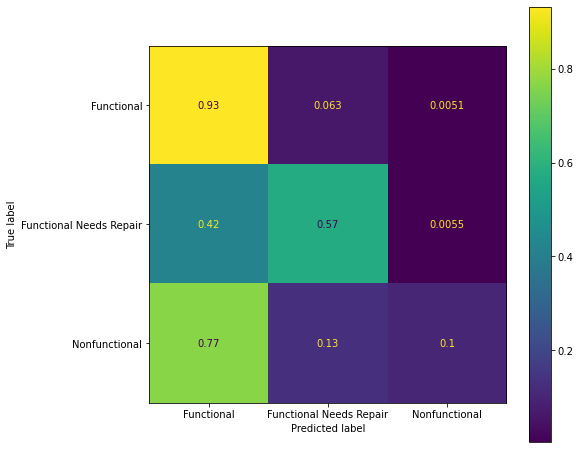

In [54]:
model_evaluation(dt1_model, X_train, y_train, X_test, y_test)

This model predicted worse on 'Functional Needs Repair' almost half of the label was not predicted right, but the first model performed better with 74% on predicting right. 'Functional' label performed better compared to the first model. It performed really bad on 'Nonfunctional' with 10% predicting it right compared to fist model predicted 35% right. 


In [55]:
dt2_model_pipe = Pipeline(steps=([("ct", CT), 
                                    ("dt", DecisionTreeClassifier(random_state = 0))]))
dt2_model_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  [1, 7]),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='constant')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                               

In [56]:
dt2_grid = [{'dt__max_depth': [1, 5, 10], 
         'dt__min_samples_split': [2, 10, 100],
         'dt__criterion': ['entropy']}]


gridsearch2 = GridSearchCV(estimator=dt2_model_pipe, 
                          param_grid=dt2_grid, 
                          scoring=scorer, 
                          cv=5)

gridsearch2.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(transformers=[('subpipe_num',
                                                                         Pipeline(steps=[('num_impute',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         [1,
                                                                          7]),
                                                                        ('subpipe_cat',
                                                                         Pipeline(steps=[('cat_impute',
                                                               

In [57]:
gridsearch2.score(X_test, y_test)

0.7345454545454545

In [58]:
gridsearch2.best_params_

{'dt__criterion': 'entropy', 'dt__max_depth': 10, 'dt__min_samples_split': 10}

In [59]:
gridsearch2.best_estimator_

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  [1, 7]),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='constant')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                               

In [60]:
dt2_output = gridsearch2.fit(X_train, y_train)
dt2_model = dt2_output.best_estimator_


    Training Accuracy Score: 0.75 
    Testing Accuracy Score: 0.73
    
    Training Precision Score: 0.76
    Testing Precision Score: 0.74 
    
    Training Recall Score: 0.75
    Testing Recall Score: 0.73 
    
    Training F1 Score: 0.73
    Testing F1 Score: 0.72 
    
    Confusion Matrix:


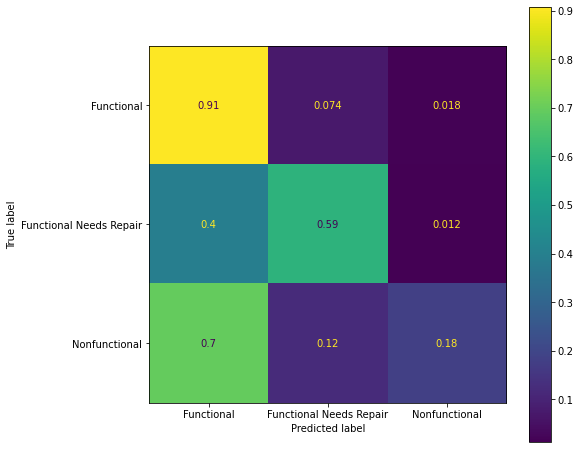

In [61]:
model_evaluation(dt2_model, X_train, y_train, X_test, y_test)

In [62]:
dt3_model_pipe = Pipeline(steps=([("ct", CT), 
                                    ("dt", DecisionTreeClassifier(random_state = 0))]))
dt3_model_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  [1, 7]),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='constant')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                               

In [63]:
from sklearn.ensemble import ExtraTreesClassifier 

In [64]:

etc_model_pipe = Pipeline(steps=([("ct", CT), 
                                    ("etc", ExtraTreesClassifier(random_state = 42))]))
etc_model_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  [1, 7]),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='constant')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                               

In [65]:
etc_grid = [{'etc__n_estimators': [1000,  1500], 
         'etc__min_samples_split': [5, 10, 15]}]


gridsearch3 = GridSearchCV(estimator=etc_model_pipe, 
                          param_grid=etc_grid, 
                          scoring=scorer, 
                          cv=5)

gridsearch3.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(transformers=[('subpipe_num',
                                                                         Pipeline(steps=[('num_impute',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         [1,
                                                                          7]),
                                                                        ('subpipe_cat',
                                                                         Pipeline(steps=[('cat_impute',
                                                               

In [66]:
gridsearch3.score(X_test, y_test)

0.7894276094276095

In [67]:
gridsearch3.best_params_

{'etc__min_samples_split': 15, 'etc__n_estimators': 1500}

In [68]:
gridsearch3.best_estimator_

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  [1, 7]),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='constant')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                               

In [69]:
etc_output = gridsearch3.fit(X_train, y_train)
etc_model = etc_output.best_estimator_


    Training Accuracy Score: 0.87 
    Testing Accuracy Score: 0.79
    
    Training Precision Score: 0.87
    Testing Precision Score: 0.78 
    
    Training Recall Score: 0.87
    Testing Recall Score: 0.79 
    
    Training F1 Score: 0.86
    Testing F1 Score: 0.78 
    
    Confusion Matrix:


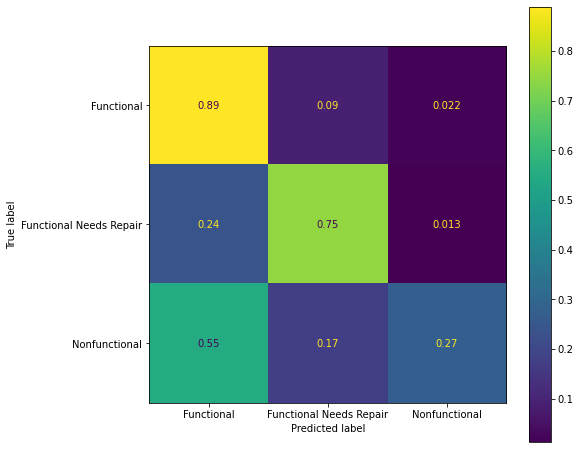

In [71]:
model_evaluation(etc_model, X_train, y_train, X_test, y_test)

Text(0, 0.5, 'Prediction Percentage')

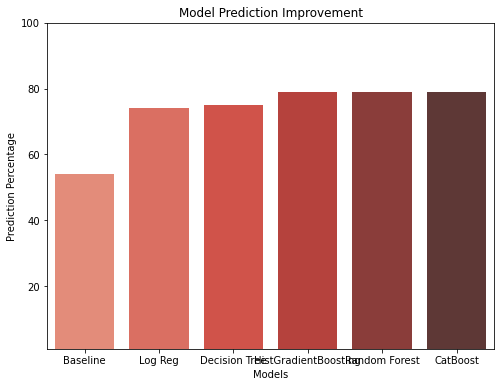

In [72]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(8, 6))
Percent_Accuracy = [54, 74, 75, 78.9, 79, 79]
Models = ["Baseline", "Logistic Regression", "Decision Tree", "HistGradientBoosting", "Random Forest", "CatBoost"]
ax = sns.barplot(x= Models, y= Percent_Accuracy, palette='Reds_d')
ax.set_ylim(1, 100)
ax.set_title("Model Prediction Improvement")
ax.set_xlabel("Models")
ax.set_ylabel("Prediction Percentage");